# Project Description and Goals

The Zillow Data Science Team wants to be able to predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August 2017.

Additionally, information is needed outside of the model. Because property taxes are assessed at the county level, the team would like to know:
- What states and counties these are located in?
- What is the distribution of tax rates for each county?

### Objectives for this project include:
- Identifying and finding the features/drivers for predicting home values using the tax assessed value.
- Documenting process and analysis throughout the data science pipeline.
- Constructing a regression model that predicts home values for Zillow.
- Deliverables:
    - README.md file containing overall project information.
    - Jupyter Notebook Report detailing the pipeline process.
    - Report/presentation slides that summarize findings about the drivers of the single unit property values.
    - Python file that houses functions to acquire and prepare data.
    
### Pipeline Process:
1. Acquire
2. Prepare
3. Explore
4. Model/Evaluate
5. Deliver

### Initial hypotheses
- Is there a correlation between square footage of a home and its tax value?
- Is there a difference in tax value for homes one county vs the other? (fips county codes will be needed)
- Is there a difference in tax value for homes with a property age over 50 vs the homes that are less than 50?

### Project Imports

In [104]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#acquires and preps data
import wrangle

#split and scale functions
from sklearn.model_selection import train_test_split
from wrangle import Min_Max_Scaler

#statistical testing
from scipy import stats

# evaluating/modeling methods
import math
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


# Data Acquisition

In [2]:
#df = wrangle.get_zillow_data()

#df.head()

In [3]:
#if faster connection is desired, uncomment, and run the following code
df = wrangle.cached_zillow(cached=True)
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30


### Initial Data Summarization

In [4]:
#rows and columns
df.shape

(38622, 62)

In [5]:
#list of column names and data types with more information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38622 entries, 0 to 38621
Data columns (total 62 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      38622 non-null  int64  
 1   id                            38622 non-null  int64  
 2   airconditioningtypeid         12224 non-null  float64
 3   architecturalstyletypeid      101 non-null    float64
 4   basementsqft                  27 non-null     float64
 5   bathroomcnt                   38622 non-null  float64
 6   bedroomcnt                    38622 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         23706 non-null  float64
 9   calculatedbathnbr             38463 non-null  float64
 10  decktypeid                    333 non-null    float64
 11  finishedfloor1squarefeet      3339 non-null   float64
 12  calculatedfinishedsquarefeet  38509 non-null  float64
 13  f

In [6]:
df.isnull().sum()

parcelid                        0
id                              0
airconditioningtypeid       26398
architecturalstyletypeid    38521
basementsqft                38595
                            ...  
taxdelinquencyyear          37354
censustractandblock           144
id.1                            0
logerror                        0
transactiondate                 0
Length: 62, dtype: int64

In [7]:
sum_features = df[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'taxvaluedollarcnt']]

sum_features.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,38622.0,3.010512,1.029506,0.0,2.0,3.0,4.0,12.0
bathroomcnt,38622.0,2.273743,0.950588,0.0,2.0,2.0,3.0,11.0
calculatedfinishedsquarefeet,38509.0,1762.746709,928.300281,240.0,1174.0,1525.0,2082.0,17245.0
taxvaluedollarcnt,38621.0,496577.879651,632690.906146,1000.0,209051.0,363516.0,577804.0,23858374.0


Text(0.5, 1.0, 'Distribution of square feet')

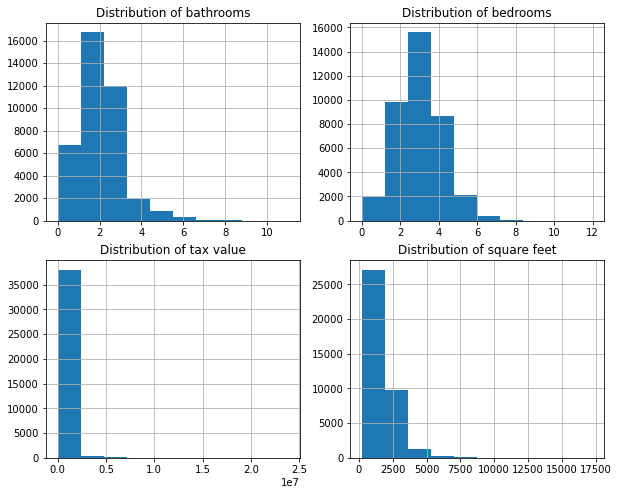

In [8]:
# use subplots to view distribution of numeric columns
plt.figure(figsize=(10, 8))

plt.subplot(221)
df.bathroomcnt.hist()
plt.gca().set_title('Distribution of bathrooms')


plt.subplot(222)
df.bedroomcnt.hist()
plt.gca().set_title('Distribution of bedrooms')

plt.subplot(223)
df.taxvaluedollarcnt.hist() 
plt.gca().set_title('Distribution of tax value')

plt.subplot(224)
df.calculatedfinishedsquarefeet.hist()
plt.gca().set_title('Distribution of square feet')

### Findings
- There are many, many nulls in this dataset. Columns with nulls need to be removed and/or filled in.
- Some columns have repeated and/or unnecessary information so those will need to be removed as well. 
- Column names are too long and can be shortened/have better titles for readability.
- Column for age of property would be useful.
- Outliers exist in `taxvaluedollarcnt` and `calculatedfinishedsquarefeet` and can be removed by calculating IQR, upper bound and lower bound.
- Datatypes can be converted to integers for a cleaner dataframe. 
- Data should be scaled as well.
- As for project goals, keep in mind that additional information is needed outside of the model (county locations and tax rates for each county is needed), so a column calculating tax rate is needed along with county names/codes.

# Data Preparation

In [9]:
df = wrangle.clean_zillow(df)
df.head()

,bedrooms,bathrooms,square_feet,county_fips_code,age,tax_value,taxes,tax_rate
parcelid,,,,,,,,
14634203,3,2.0,1125,6059,43,289445,3490.16,1.205811
11721753,3,2.0,1316,6037,94,205123,2627.48,1.280929
11289917,3,2.0,1458,6037,47,136104,2319.90,1.704505
11637029,3,2.0,1766,6037,37,810694,9407.01,1.160365
11705026,2,1.0,1421,6037,106,35606,543.69,1.526962


In [10]:
df.dtypes

bedrooms              int64
bathrooms           float64
square_feet           int64
county_fips_code      int64
age                   int64
tax_value             int64
taxes               float64
tax_rate            float64
dtype: object

In [11]:
df.isnull().sum()

bedrooms            0
bathrooms           0
square_feet         0
county_fips_code    0
age                 0
tax_value           0
taxes               0
tax_rate            0
dtype: int64

### Why are these fields used?

Insert data dictionary here

In [12]:
#split the data using the split function in wrangle.py
train, validate, test = wrangle.split(df)

In [13]:
#check split datasets
print('overall shape of dataframe:', df.shape)
print('train:', train.shape)
print('validate:', validate.shape)
print('test:', test.shape)

#work w/ training data for data exploration
train.head()

overall shape of dataframe: (34837, 8)
train: (19508, 8)
validate: (8361, 8)
test: (6968, 8)


,bedrooms,bathrooms,square_feet,county_fips_code,age,tax_value,taxes,tax_rate
parcelid,,,,,,,,
10712731,3,2.0,1962,6037,54,86942,1250.36,1.438154
17139143,2,2.0,1070,6111,39,78600,811.60,1.032570
12488599,2,1.0,1132,6037,75,228724,3064.44,1.339798
14308150,2,2.0,1208,6059,37,698413,7276.00,1.041790
14444150,3,2.0,1855,6059,52,301297,2998.30,0.995131


In [14]:
#set up X inputs and y target variable for each split 
X_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

X_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

X_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [15]:
#scaling the data using the Min_Max_Scaler function from wrangle.py
X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

X_train_scaled.head()

,bedrooms,bathrooms,square_feet,county_fips_code,age,taxes,tax_rate
parcelid,,,,,,,
10712731,0.333333,0.266667,0.537957,0.000000,0.404580,0.050539,0.048317
17139143,0.222222,0.266667,0.259294,1.000000,0.290076,0.032517,0.034555
12488599,0.222222,0.133333,0.278663,0.000000,0.564885,0.125049,0.044980
14308150,0.222222,0.266667,0.302405,0.297297,0.274809,0.298034,0.034868
14444150,0.333333,0.266667,0.504530,0.297297,0.389313,0.122333,0.033285


#### Data is:
   - cleaned/prepped by specifying required features, renaming columns, adding calculated features, handling missing values, changing data types, and removing outliers.
   - split into train, validate, test for exploration.
   - set up with X inputs and y target variables for each split for model/evaluation.
   - scaled into X_train_scaled, X_validate_scaled, and X_test_scaled for model/evaluation.
   - ready to be explored on training (in-sample) data.

# Data Exploration

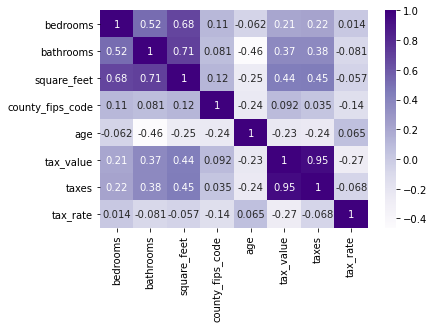

In [16]:
#exploring correlation using heatmap
sns.heatmap(train.corr(), cmap='Purples', annot=True)

plt.show()

### Findings
- The darker/lighter the colors on heatmap, the more of a correlation.
- Tax_value seems to correlate the most with square_feet.
- Number of bathrooms correlates more with tax_value than number of bedrooms.

In [17]:
def plot_variable_pairs(train):
    '''
    This function will accept a dataframe as input 
    and plot all the pairwise relationships with the regression line for each pair
    '''
    sns.pairplot(train, 
                kind = "reg", 
                plot_kws = {'line_kws': {'color': 'red'}}) 

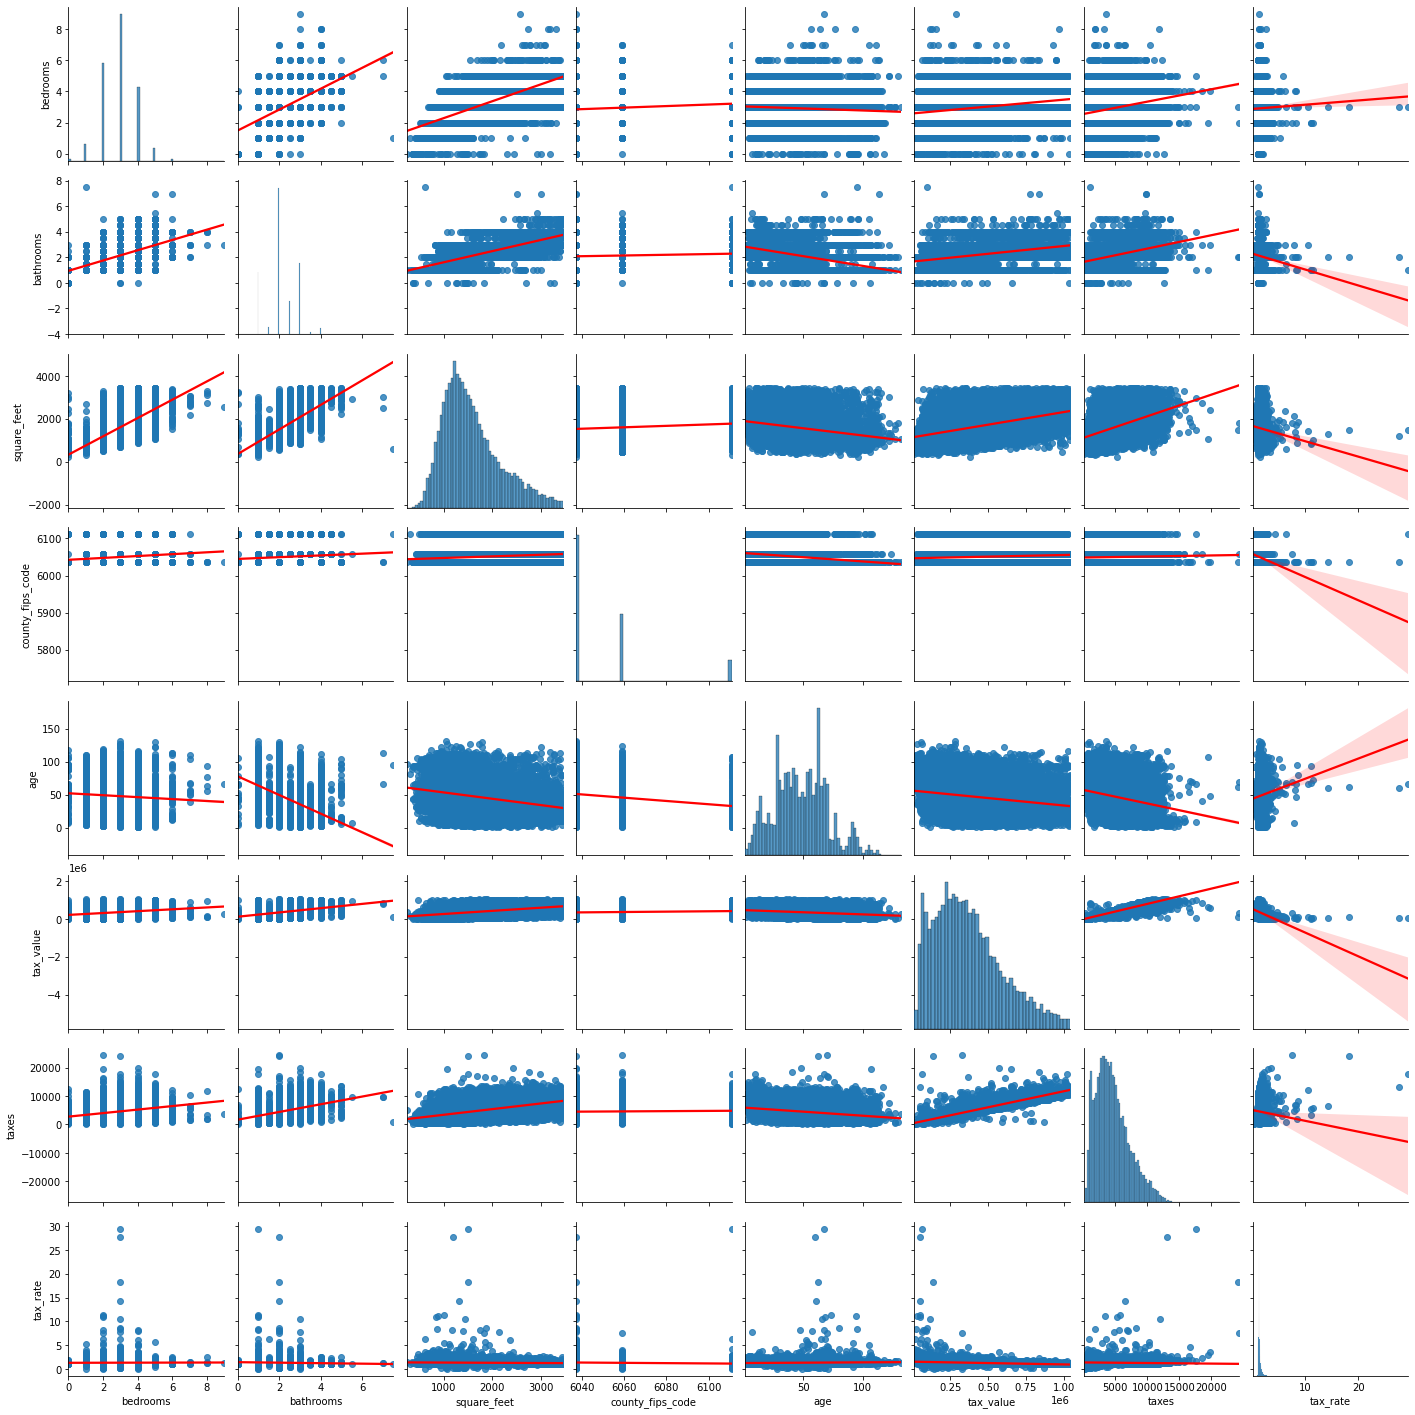

In [18]:
#visualize pairwise relationships w/ regression line
plot_variable_pairs(train)

### Findings
- Tax value seems to have a negative correlation with age of home and shows a positive correlation with square_feet, bathrooms, and bedrooms.

In [19]:
train.head(2)

,bedrooms,bathrooms,square_feet,county_fips_code,age,tax_value,taxes,tax_rate
parcelid,,,,,,,,
10712731,3,2.0,1962,6037,54,86942,1250.36,1.438154
17139143,2,2.0,1070,6111,39,78600,811.60,1.032570


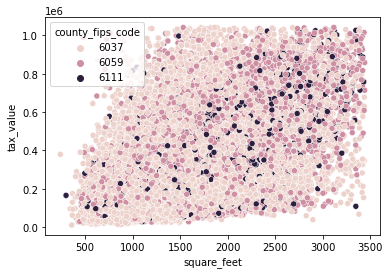

In [20]:
sns.scatterplot(data=train, x='square_feet', y='tax_value', hue = 'county_fips_code')
plt.show()

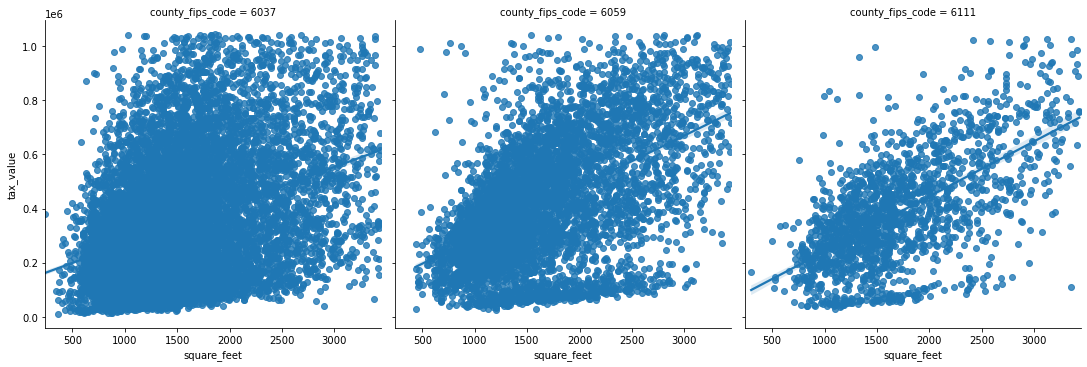

In [25]:
sns.lmplot(data=train, x='square_feet', y='tax_value', col = 'county_fips_code', col_wrap=3)
plt.show()

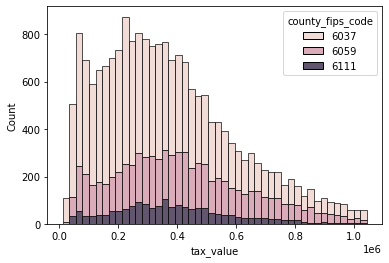

In [21]:
sns.histplot(data=train, x="tax_value", hue="county_fips_code", multiple="stack")
plt.show()

### Statistical Tests
- Correlation Test for square feet and tax value
- t-test to check if there is a difference in tax value for homes one county vs the other?
    - 1 sample b/c comparing the means of 2 subgroups
    - 2 tailed b/c checking if any difference
- t-test to check if there is a difference in tax value for homes with a property age over 50 vs the homes that are less than 50
    - 2 sample b/c comparing the means of 2 subgroups
    - 2 tailed b/c checking if any difference

In [55]:
#Correlation Test: tax value and square feet
null_hypothesis = "there is no correlation between tax value and square footage of a home"
alternative_hypothesis = "there is a correlation between tax value and square footage of a home"
confidence_level = .95
alpha = 1 - confidence_level

#Use pearsonr function
corr, p = stats.pearsonr(train.square_feet, train.tax_value)


print(f"Pearson's correlation coefficient: {corr} and p-value is: {p}")

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We can move forward with the alternative hypothesis: ", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)
    

Pearson's correlation coefficient: 0.44280279764168384 and p-value is: 0.0
We reject the null hypothesis that there is no correlation between tax value and square footage of a home
We can move forward with the alternative hypothesis:  there is a correlation between tax value and square footage of a home


In [56]:
#T-test: tax value and counties
null_hypothesis = "there is no difference in tax value between los angeles county and the rest of the counties"
alternative_hypothesis = "there is a difference in tax value"
confidence_level = .95
alpha = 1 - confidence_level

la_county = train[train.county_fips_code  == 6037].tax_value
other_counties = train[train.county_fips_code != 6037].tax_value

t, p = stats.ttest_ind(la_county, other_counties)

print(t, p)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We can move forward with the alternative hypothesis: ", alternative_hypothesis)

else:
    print("We fail to reject the null hypothesis")
    print("Not enough evidence to support", alternative_hypothesis)

-20.680342404375658 5.305697388957119e-94
We reject the null hypothesis that there is no difference in tax value between los angeles county and the rest of the counties
We can move forward with the alternative hypothesis:  there is a difference in tax value


In [57]:
#T-test: tax value and age of property
null_hypothesis = "there is no difference in tax value between homes with a property age of over 50 vs age of under 50"
alternative_hypothesis = "there is a difference in tax value"
confidence_level = .95
alpha = 1 - confidence_level

over_50 = train[train.age > 50].tax_value
under_50 = train[train.age < 50].tax_value

t, p = stats.ttest_ind(over_50, under_50)

print(t, p)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We can move forward with the alternative hypothesis: ", alternative_hypothesis)

else:
    print("We fail to reject the null hypothesis")
    print(alternative_hypothesis)

-24.439027219527798 6.0912971113267595e-130
We reject the null hypothesis that there is no difference in tax value between homes with a property age of over 50 vs age of under 50
We can move forward with the alternative hypothesis:  there is a difference in tax value


# Data Modeling and Evaluation

In [72]:
#defining functions to get evaluation metrics for models
def residuals(actual, predicted):
    return actual - predicted

def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def evaluation_metrics_mean(actual):
    predicted = actual.mean()
    return {'sse': sse(actual, predicted), 
            'mse': mse(actual, predicted), 
            'rmse': rmse(actual, predicted)}

def evaluation_metrics_median(actual):
    predicted = actual.median()
    return {'sse': sse(actual, predicted), 
            'mse': mse(actual, predicted), 
            'rmse': rmse(actual, predicted)}

### Establish/Evaluate a Baseline Model

In [84]:
#Convert y_train and y_validate to dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Predict tax_value_pred_mean
tax_value_pred_mean = y_train.tax_value.mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#Compute tax_value_pred_median
tax_value_pred_median = y_train.tax_value.median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

In [76]:
#Evaluate the baseline model using the mean
evaluation_metrics_mean(y_train.tax_value)

{'sse': 983333176058051.1,
 'mse': 50406662705.456795,
 'rmse': 224514.28174050932}

In [77]:
#Evaluate the baseline model using the median
evaluation_metrics_median(y_train.tax_value)

{'sse': 1005616490831297.0,
 'mse': 51548928174.66152,
 'rmse': 227043.89041474232}

### Findings:
- Using the mean for the baseline will be the benchmark for comparison since it performed better than using the median.
- RMSE metric gives an overall lower value, so moving forward with obtaining/comparing RMSE between baseline and models.

In [78]:
#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  224514.28 
Validate/Out-of-Sample:  226126.54


In [90]:
#incrementally building a df for comparison of metrics for model selection
metric_df = pd.DataFrame(data = [{'model': 'mean_baseline', 
                                  'RMSE_validate': rmse_validate,
                                  'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_mean)}])

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.0


#### Before moving into the models, let's find which are the best features to feed into the models using defined functions for Select K Best and Recursive Feature Elimination (RFE)

In [105]:
def select_kbest(X, y, k_num):
    '''
    This function takes in the predictors X (X_train) or (X_train_scaled), 
    the target Y (y_train), 
    and the number of features to select (k_num),
    
    fits the object to the data, 
    
    uses get_support() to get the list of features,
    
    and returns the names of the top k selected features
    '''
    
    #make
    f_selector = SelectKBest(f_regression, k=k_num)
    
    #fit
    f_selector.fit(X, y)
    
    #use
    feature_mask = f_selector.get_support()
    
    #get list
    f_feature = X.iloc[:, feature_mask].columns.tolist()

    return f_feature

In [106]:
#calling function with X_train_scaled (predictors), y_train (target), and k
print(f'Top 3 features to predict tax value are: {select_kbest(X_train_scaled, y_train, 3)}')

ValueError: y should be a 1d array, got an array of shape (19508, 7) instead.

## LinearRegression (OLS)

In [91]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled, y_train.tax_value)


# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)


# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  49088.80040537587 
Validation/Out-of-Sample:  48282.74547890232


In [92]:
metric_df = metric_df.append({'model': 'OLS Regressor', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.000000
1,OLS Regressor,48282.745479,0.954406


## LassoLars

In [93]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  49088.80040537587 
Validation/Out-of-Sample:  48282.74547890232


In [94]:
metric_df = metric_df.append({'model': 'Lasso alpha 1', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lars)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.000000
1,OLS Regressor,48282.745479,0.954406
2,Lasso alpha 1,48282.745479,0.954391


## TweedieRegressor (GLM)

In [95]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  66519.59126800289 
Validation/Out-of-Sample:  66519.59126800289


In [96]:
metric_df = metric_df.append({'model': 'GLS (Poisson)', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_glm)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,226126.536116,0.000000
1,OLS Regressor,48282.745479,0.954406
2,Lasso alpha 1,48282.745479,0.954391
3,GLS (Poisson),66519.591268,0.899199


## Polynomial Regression

In [97]:
## Polynomial Features ##
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 =  pf.transform(X_test_scaled)


## LinearRegression ##
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_scaled, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  49088.80040537587 
Validation/Out-of-Sample:  2331223510.980462


In [98]:
metric_df = metric_df.append({'model': 'Quadratic Model', 
                              'RMSE_validate': rmse_validate, 
                              'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm2)}, ignore_index=True)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,2.261265e+05,0.000000
1,OLS Regressor,4.828275e+04,0.954406
2,Lasso alpha 1,4.828275e+04,0.954391
3,GLS (Poisson),6.651959e+04,0.899199
4,Quadratic Model,2.331224e+09,0.954406


## Evaluate

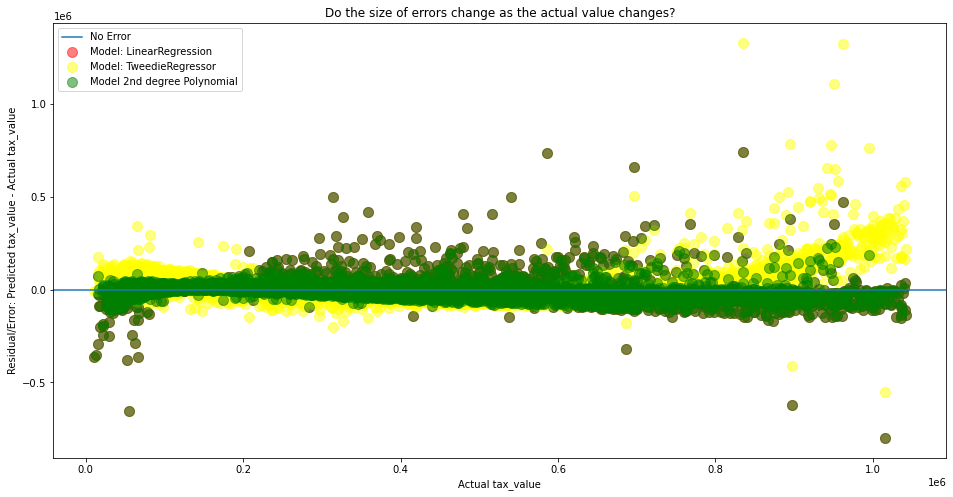

In [99]:
#residual plots: plotting the errors in predictions
# y_validate.head()
plt.figure(figsize=(16,8))

plt.axhline(label="No Error")

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm - y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm - y_validate.tax_value, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm2 - y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual tax_value")
plt.ylabel("Residual/Error: Predicted tax_value - Actual tax_value")
plt.title("Do the size of errors change as the actual value changes?")

plt.show()

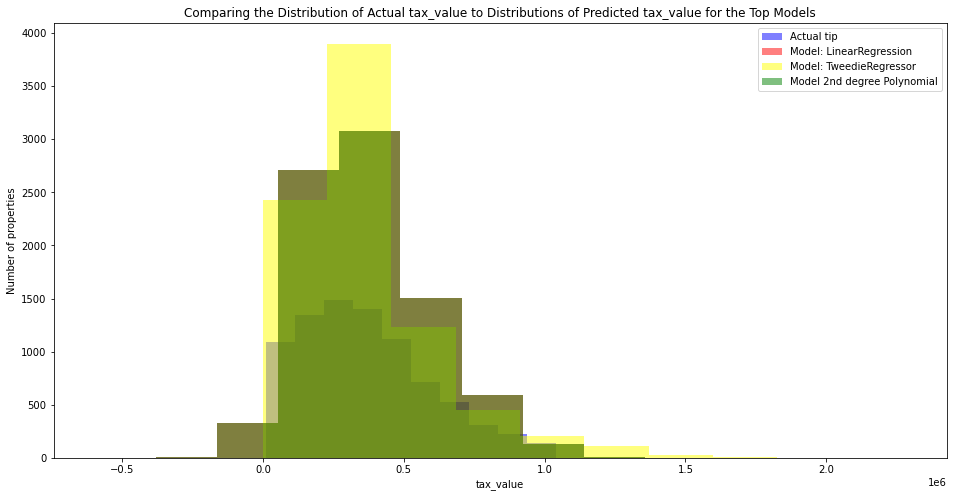

In [100]:
#histogram
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))

plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual tip")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("tax_value")
plt.ylabel("Number of properties")
plt.title("Comparing the Distribution of Actual tax_value to Distributions of Predicted tax_value for the Top Models")
plt.legend()
plt.show()

In [101]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  107004.97392852453


### Findings
- Model selected: 